In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling imports
import xgboost as xgb
import joblib
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA


# evaluation imports
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, roc_auc_score

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

import yaml

In [2]:
def fill_triage_data_based_on_time(df, df_triage, df_time, time):
    """ Fills the dataframe with triage data based on the available information at that give timestamp """

    include_triage = df_time['TRIAGE'] < (df_time['AANKOMST'] + pd.Timedelta(minutes=time))
    df.loc[include_triage, triage_cols] = df_triage.loc[include_triage, triage_cols]

    return df

    
def fill_lab_data_based_on_time(df, df_lab, time):
    """ Fills the dataframe with lab data based on the available information at that give timestamp """

    df_lab['CURRENT_TIME'] = df_lab['AANKOMST_TIJDSTIP'] + pd.Timedelta(minutes=time)
    
    # fill the lab values
    for lab_val in lab_vals:
        # set all the taken lab values to -1
        df_lab_val = df_lab[(df_lab['DESC'] == lab_val) & (df_lab['CURRENT_TIME'] > df_lab['AFNAME_TIJDSTIP'])]
        ids_taken_labs = df_lab_val.groupby('SEHID').last().reset_index()[['SEHID', 'UITSLAG']]  # SEHID for whom the lab was taken
        ids_taken_labs = ids_taken_labs.loc[ids_taken_labs['SEHID'].isin(df.index)]  # filter out SEHIDs who are not in our SEH df
        df.loc[ids_taken_labs['SEHID'].tolist(), lab_val] = -1

        # if the lab result has arrived set it tot that value (else it will stay -1)
        df_lab_val = df_lab[(df_lab['DESC'] == lab_val) & (df_lab['CURRENT_TIME'] > df_lab['UITSLAG_TIJDSTIP'])]
        lab_results = df_lab_val.groupby('SEHID').last().reset_index()[['SEHID', 'UITSLAG']]  # SEHID and labresult for whom it is available
        lab_results = lab_results.loc[lab_results['SEHID'].isin(df.index)]  # filter out SEHIDs who are not in our SEH df

        lab_ids = lab_results['SEHID'].tolist()
        lab_res = lab_results['UITSLAG'].tolist()
        df.loc[lab_ids, lab_val] = lab_res

        # df.loc[df[lab_val].isna(), lab_val] = np.mean(df_lab[df_lab['DESC'] == lab_val]['UITSLAG'])
    
    return df.fillna(np.nan)


def fill_vital_data_based_on_time(df, df_vitals, time):
    """ Fills the dataframe with vital data based on the available information at that give timestamp """

    df_vitals['CURRENT_TIME'] = df_vitals['AANKOMST'] + pd.Timedelta(minutes=time)

    for vital in vitals:

        df_vital_val = df_vitals[(df_vitals['LABEL'] == vital) & (df_vitals['CURRENT_TIME'] > df_vitals['DateTime'])]
        vital_results = df_vital_val.groupby('SEHID').last().reset_index()[['SEHID', 'Value1']]
        vital_results = vital_results.loc[vital_results['SEHID'].isin(df.index)] 
        df.loc[vital_results['SEHID'].tolist(), vital] = vital_results['Value1'].tolist()
        # df.loc[df[vital].isna(), vital] = np.mean(df_vitals[df_vitals['LABEL'] == vital]['Value1'])
    
    return df.fillna(np.nan)


def exclude_completed_ed_visits(df, df_time, time):
    """ Excludes entries from the df if they left the ED """
    
    start_len = len(df)
    include_ed_vist = ((df_time['AANKOMST'] + pd.Timedelta(minutes=time))  < df_time['EIND']).tolist()
    df = df[include_ed_vist]
    end_len = len(df)
    print(f'Removed {(start_len - end_len) / start_len * 100:.2f}%')

    return df


def train_nlp_vec(text_train):
    """ Trains an NLP vectorizer (TFIDF) """

    dutch_stop_words = set(stopwords.words('dutch'))
    vec = TfidfVectorizer(ngram_range=(1, 6), stop_words=dutch_stop_words)
    vec.fit(text_train.astype(str))

    return vec


def train_model(X_train, y_train, model):
    """ General function to train a model on the trainingsdata """

    assert X_train.shape[0] == y_train.shape[0]
    model.fit(X_train, y_train)

    return model


def get_prediction(X_test, trained_model):
    """ Gets predictions of test data on the trained model """

    y_pred       = trained_model.predict(X_test)
    y_pred_proba = trained_model.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


def get_text_preds(ids_train, y_train, model):
    """ Gets the predictions of text data using a trained model"""

    text_train = df_seh.loc[ids_train]['KLACHT']
    vec = train_nlp_vec(text_train)

    text_train_transformed = vec.transform(text_train)
    nlp_model = train_model(text_train_transformed, y_train, model)

    text_transformed = vec.transform(df_seh['KLACHT'])
    _, y_preds = get_prediction(text_transformed, nlp_model)

    return y_preds, nlp_model, vec


def train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, model, start_time=0, end_time=190, interval=10, can_handle_na=True, can_handle_neg=True):
    """ Trains a model for all the given timestamps where it evaluates which data is available. It used different metrics to evaluatie the performance of the model """

    # dictionaries to save results
    res = {}
    feature_importance_per_time = {}    

    # Initialise and fill run df with availabe data at time = 0 min
    df_run = pd.DataFrame(columns=all_cols, index=df_seh.index)
    df_run[[*aankomst_cols, 'OPNAME']] = df_seh[[*aankomst_cols, 'OPNAME']]

    # transform text and get text predictions
    
    df_run['KLACHT_PRED'], _, _ = get_text_preds(ids_train, y_train, LogisticRegression(max_iter=1e3))

    for time in range(start_time, end_time, interval):

        # Check to include or exclude data based on the simulation time
        df_run = fill_triage_data_based_on_time(df_run, df_seh, df_time, time)
        df_run = fill_lab_data_based_on_time(df_run, df_lab, time)
        df_run = fill_vital_data_based_on_time(df_run, df_vitals, time)

        if not can_handle_na:
            df_run = df_run.fillna(-1)
        if not can_handle_neg:
            num = df_run._get_numeric_data()
            num[num < 0] = 0

        # df_run = df_run[top_features]
        # Get train and test features
        X_train = df_run.loc[ids_train].drop(['OPNAME', 'KLACHT'], axis=1)
        X_test  = df_run.loc[ids_test].drop(['OPNAME', 'KLACHT'], axis=1)
        
        clf = train_model(X_train, y_train, model)
        y_pred, y_pred_proba = get_prediction(X_test, clf)

        res[time] = {'y_test':       y_test,
                     'y_pred':       y_pred,
                     'y_pred_proba': y_pred_proba}

    return res, clf


def evaluate_results(y_pred, y_pred_prob, y_test):
    """ Creates a confusion matrics of the results """

    assert y_pred.shape[0] == y_pred_prob.shape[0] == y_test.shape[0]

    # get roc evaluations
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # plot the ROC curve
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    axs[0].legend(loc='best')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')

    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(ax=axs[1], cmap='Blues', colorbar=False)

    plt.tight_layout()
    plt.show()


def generate_evaluation_report(results):
    """ Plots all the metrics for the given resulsts in one plot """

    times = []
    auc_scores = []
    sensitivity_scores = []
    specificity_scores = []
    accuracy_scores = []
    precision_scores = []
    f1_scores = []

    for time, data in results.items():
        y_test = data['y_test']
        y_pred = data['y_pred']
        y_pred_proba = data['y_pred_proba']

        auc = roc_auc_score(y_test, y_pred_proba)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        times.append(time)
        auc_scores.append(round(auc, 3))
        sensitivity_scores.append(round(sensitivity, 3))
        specificity_scores.append(round(specificity, 3))
        accuracy_scores.append(round(accuracy, 3))
        precision_scores.append(round(precision, 3))
        f1_scores.append(round(f1, 3))

    # Create a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the evaluation metrics
    ax1.plot(times, auc_scores, marker='o', linestyle='-', label='AUC')
    ax1.plot(times, sensitivity_scores, marker='o', linestyle='-', label='Sensitivity')
    ax1.plot(times, specificity_scores, marker='o', linestyle='-', label='Specificity')
    ax1.plot(times, accuracy_scores, marker='o', linestyle='-', label='Accuracy')
    ax1.plot(times, precision_scores, marker='o', linestyle='-', label='Precision')
    ax1.plot(times, f1_scores, marker='o', linestyle='-', label='F1-Score')
    ax1.set_title('Evaluation Metrics Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Scores')
    ax1.legend()

    # Create a Pandas DataFrame for tabular data
    evaluation_df = pd.DataFrame({
        'Time': times,
        'AUC': auc_scores,
        'Sensitivity': sensitivity_scores,
        'Specificity': specificity_scores,
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'F1-Score': f1_scores
    })

    # Display the tabular data in a table with larger font size
    table = ax2.table(cellText=evaluation_df.values, colLabels=evaluation_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Increase the table size
    ax2.axis('off')

    # Adjust subplot layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the combined figure
    plt.show()

    return evaluation_df

## 1. Loading the data

In [3]:
with open('./ml_config.yaml') as config_file:
    config = yaml.safe_load(config_file)

In [4]:
df_seh    = pd.read_csv(config['seh_data'], sep=';', index_col='SEHID')
df_time   = pd.read_csv(config['time_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST', 'TRIAGE', 'EIND'])
df_lab    = pd.read_csv(config['lab_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST_TIJDSTIP', 'AFNAME_TIJDSTIP', 'UITSLAG_TIJDSTIP'])
df_vitals = pd.read_csv(config['vital_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST', 'DateTime'])

/pyenvs/admission-prediction/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
# only get data before 2022, 2022 data will be used as a test set later
df_time = df_time[df_time['AANKOMST'] < '2022']
df_seh = df_seh[df_seh.index.isin(df_time.index)].drop('PATIENTNR', axis=1)
df_lab = df_lab[df_lab.index.isin(df_time.index)]
df_vitals = df_vitals[df_vitals.index.isin(df_time.index)]

In [6]:
triage_cols   = [col for col in df_seh.columns if col.startswith('klacht_')] + ['TRIANIVCOD']
aankomst_cols = [col for col in df_seh.columns if col not in triage_cols]
vitals        = df_vitals['LABEL'].unique().tolist()
lab_vals      = df_lab['DESC'].unique().tolist()
all_cols      = [*aankomst_cols, *triage_cols, *lab_vals, *vitals]

## 2. Modeling

In [7]:
ids_train, ids_test, y_train, y_test = train_test_split(df_seh.index, df_seh['OPNAME'], test_size=0.2, random_state=999, stratify=df_seh['OPNAME'])

### 2.1 Logistic regression

In [8]:
lr =  LogisticRegression(max_iter=1e8)
lr_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, lr, can_handle_na=False)

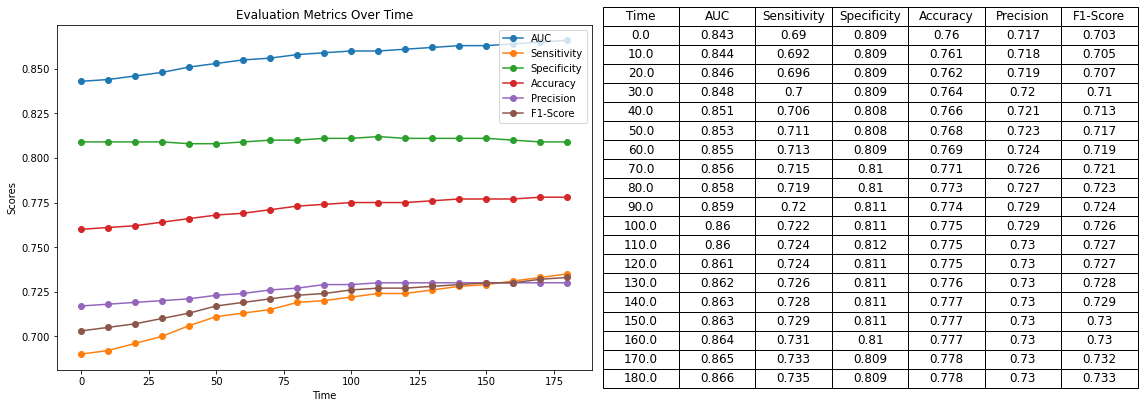

In [9]:
lr_res = generate_evaluation_report(lr_res)

### 2.2 Naive Bayes

In [10]:
nb =  GaussianNB()
nb_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, nb, can_handle_na=False, can_handle_neg=False)

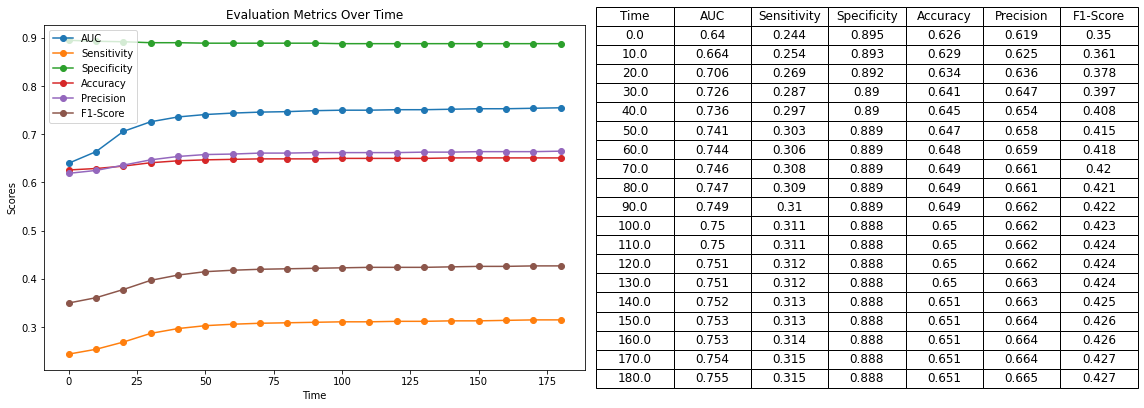

In [11]:
nb_res = generate_evaluation_report(nb_res)

### 2.3 Random Forest Classifier

In [12]:
rf =  RandomForestClassifier()
rf_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, rf, can_handle_na=False)

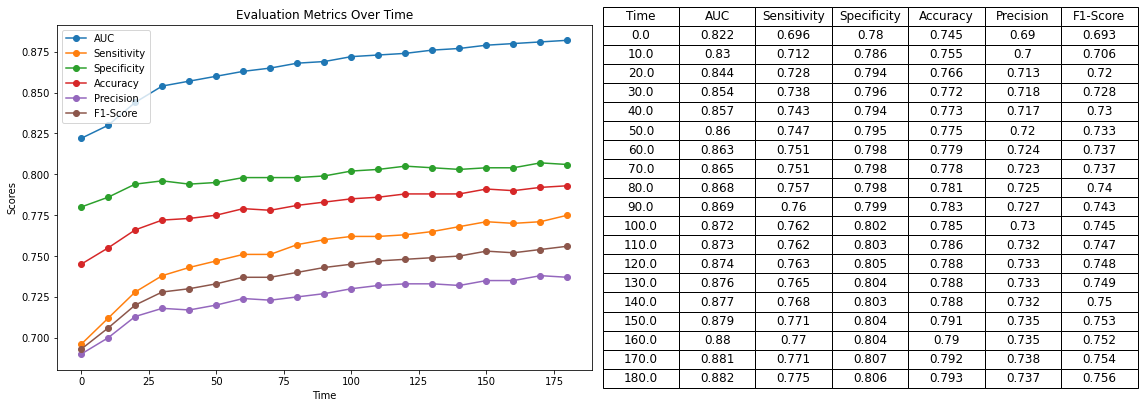

In [13]:
rf_res = generate_evaluation_report(rf_res)

### 2.4 Decision Tree Classifier

In [14]:
dt = DecisionTreeClassifier()
dt_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, dt, can_handle_na=False)

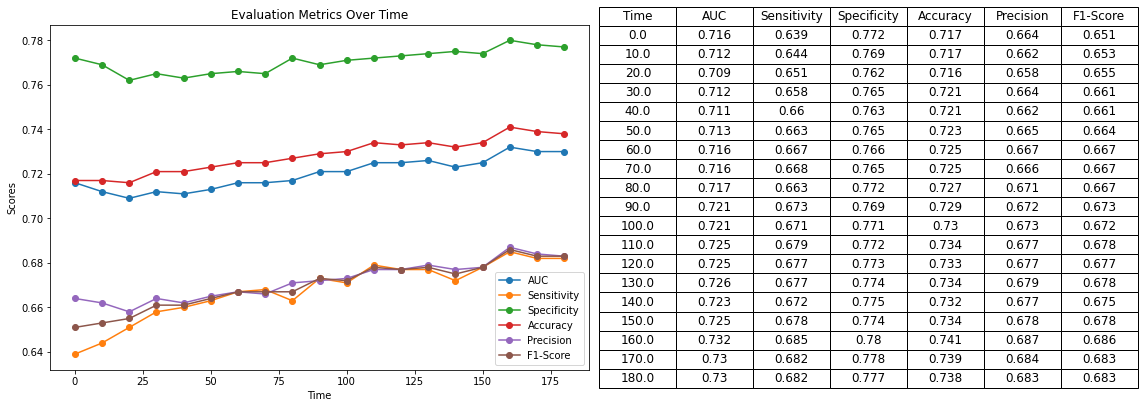

In [15]:
dt_res = generate_evaluation_report(dt_res)

### 2.5 Bagging classifier

In [16]:
bag = BaggingClassifier()
bag_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, bag, can_handle_na=False)

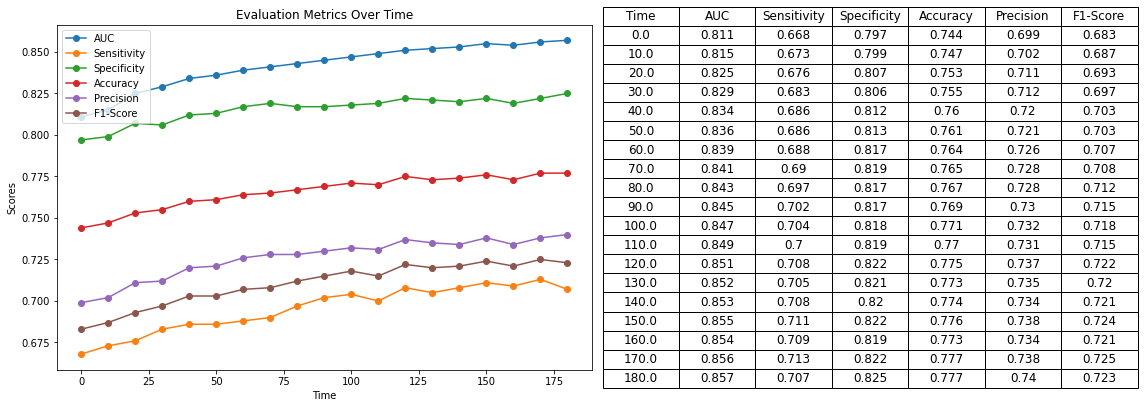

In [17]:
bag_res = generate_evaluation_report(bag_res)

### 2.6 Gradient Boosting Classifier

In [18]:
gb =  GradientBoostingClassifier()
gb_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, gb, can_handle_na=False)

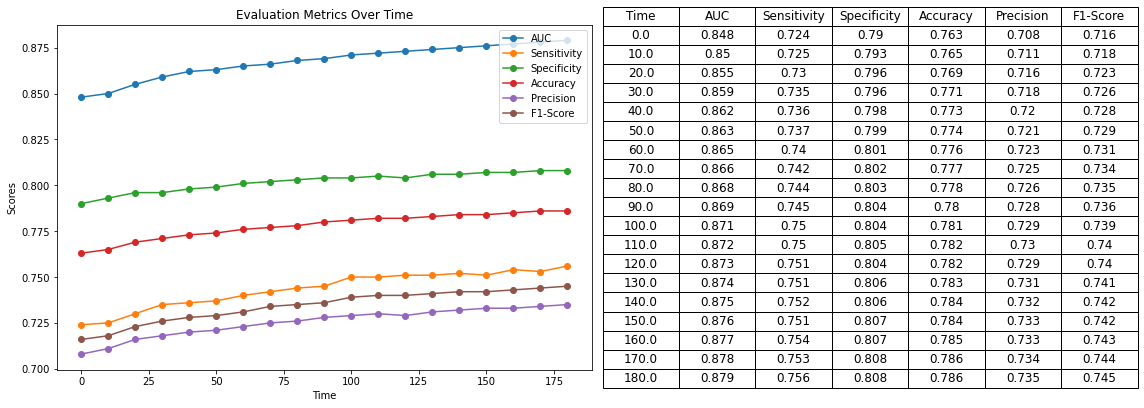

In [19]:
gb_res = generate_evaluation_report(gb_res)

### 2.7 Extreme Gradient Boosting Classifier

In [20]:
xgboost =  xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_res, _ = train_and_evaluate_model_over_time(ids_train, y_train, ids_test, y_test, xgboost, can_handle_na=True)

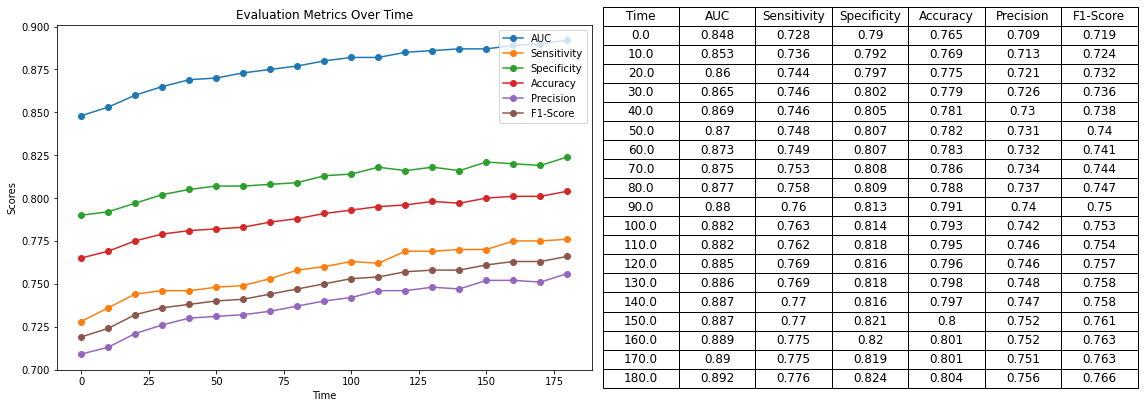

In [21]:
xgb_res = generate_evaluation_report(xgb_res)

## 3. Model selection

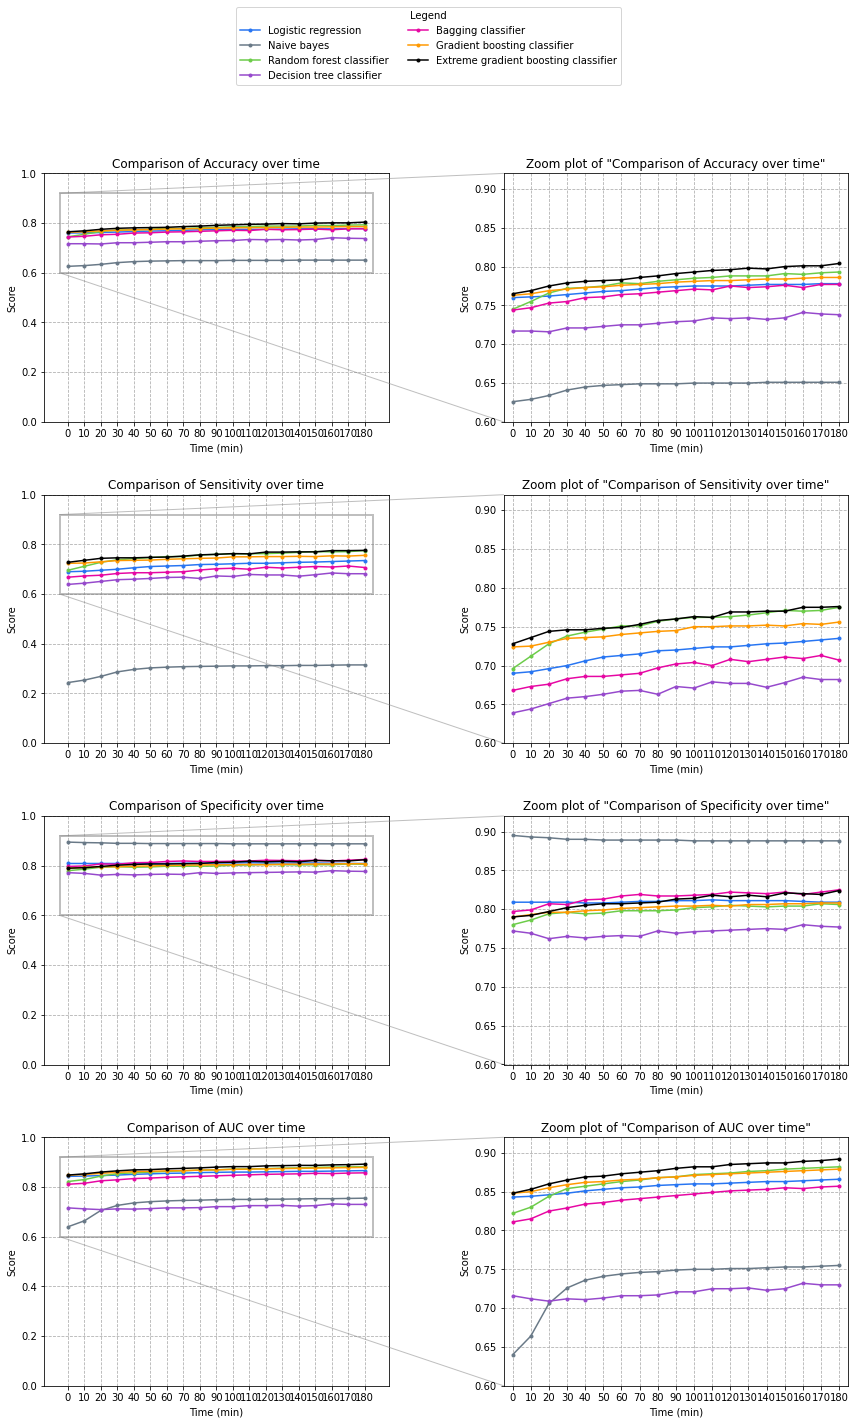

In [22]:
results = {'Logistic regression': lr_res, 
            'Naive bayes': nb_res, 
            'Random forest classifier': rf_res,
            'Decision tree classifier': dt_res, 
            'Bagging classifier': bag_res, 
            'Gradient boosting classifier': gb_res,
            'Extreme gradient boosting classifier': xgb_res}
colors = {
            "Logistic regression": '#2775f2',
            "Naive bayes":'#697987',
            "Random forest classifier": '#6ccc49',
            "Decision tree classifier": '#9649cc',
            "Bagging classifier": '#e607a3',
            "Gradient boosting classifier": '#ff9900',
            "Extreme gradient boosting classifier": 'black'
          }


sorter = ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
n_rows = 4
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 18))
for row in range(n_rows):
    metric = sorter[row]
    col = 0
    for model in results.keys():
        y_data = results[model][metric]
        ax[row, col].plot(range(0, 190, 10), y_data, '.-', color=colors[model], label=model)
        ax[row, col+1].plot(range(0, 190, 10), y_data, '.-',color=colors[model], label=model)
    ax[row, col].set_ylim(0, 1)
    ax[row, col].grid(linestyle='--')
    ax[row, col+1].grid(linestyle='--')
    
    # zoom = zooms[metric]
    ax[row, col+1].set_ylim(0.6, 0.92)#zoom[0], zoom[1])
    ax[row, col+1].set_xlim(-5, 185)
    ax[row, col].indicate_inset_zoom(ax[row, col+1], linewidth=2, capstyle='projecting')
    
    ax[row, col].set_title(f'\nComparison of {metric} over time')
    ax[row, col+1].set_title(f'\nZoom plot of "Comparison of {metric} over time"')
    
    ax[row, col].set_xlabel('Time (min)')
    ax[row, col+1].set_xlabel('Time (min)')
    
    ax[row, col].set_ylabel('Score')
    ax[row, col+1].set_ylabel('Score')
    
    ax[row, col].set_xticks(range(0, 190, 10))
    ax[row, col+1].set_xticks(range(0, 190, 10))
    
    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title="Legend", bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.show()


## 4. Model optimization

In [23]:
from skopt import BayesSearchCV, space
import joblib
import warnings
warnings.filterwarnings("ignore")  # future warnings

# Initialise and fill run df with availabe data at time = 0 min
df_run = pd.DataFrame(columns=all_cols, index=df_seh.index)
df_run[[*aankomst_cols, 'OPNAME']] = df_seh[[*aankomst_cols, 'OPNAME']]

# transform text and get text predictions
df_run['KLACHT_PRED'], nlp_model, vec = get_text_preds(ids_train, y_train, LogisticRegression(max_iter=1e3))
joblib.dump(vec, 'klacht_vec.joblib')
joblib.dump(nlp_model, 'klacht_lr_model.joblib')

for time in range(0, 190, 10):

    print(f'time = {time}')

    # Check to include or exclude data based on the simulation time
    df_run = fill_triage_data_based_on_time(df_run, df_seh, df_time, time)
    df_run = fill_lab_data_based_on_time(df_run, df_lab, time)
    df_run = fill_vital_data_based_on_time(df_run, df_vitals, time)

    # Get train and test features
    X, y = df_run.drop(['OPNAME', 'KLACHT'], axis=1), df_run['OPNAME']
    X_train = X.loc[ids_train]
    X_test = X.loc[ids_test]
    y_train = y.loc[ids_train]
    y_test = y.loc[ids_test]
    
    # Define the hyperparameter search space
    param_space = {
        'eval_metric': ['auc'],
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (2, 20),
        'min_child_weight': (1, 10),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'gamma': (0.01, 10.0, 'log-uniform'),
    }


    # Initialize the Bayesian Optimization optimizer
    opt = BayesSearchCV(
        estimator=xgb.XGBClassifier(),
        search_spaces=param_space,
        scoring='roc_auc',  
        n_iter=50,  
        cv=5,  
    )

    # Run Bayesian Optimization
    opt.fit(X_train, y_train)

    # Retrieve the best hyperparameters
    best_params = opt.best_params_
    best_score = opt.best_score_

    # Train the final model with the best hyperparameters
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(X_train, y_train)

    # Evaluate the final model on a separate test dataset
    final_model_score = roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])

    print("Best Hyperparameters:", best_params)
    print("Best Score (ROC AUC):", best_score)
    print("Final Model Score on Eval Data:", final_model_score)
    print()

    # Save the final model
    # joblib.dump(final_model, f'{time}_min_xgboost.joblib')

time = 0
Best Hyperparameters: OrderedDict([('colsample_bytree', 0.50936680030122), ('eval_metric', 'auc'), ('gamma', 7.393512000890579), ('learning_rate', 0.18684917090499367), ('max_depth', 16), ('min_child_weight', 4), ('subsample', 0.9632288952991748)])
Best Score (ROC AUC): 0.8993797516690016
Final Model Score on Eval Data: 0.8486707014246855

time = 10
Best Hyperparameters: OrderedDict([('colsample_bytree', 0.6317215298786945), ('eval_metric', 'auc'), ('gamma', 4.198393183762226), ('learning_rate', 0.044745621433865436), ('max_depth', 20), ('min_child_weight', 9), ('subsample', 0.9564123386603889)])
Best Score (ROC AUC): 0.901356734869546
Final Model Score on Eval Data: 0.8554956855515338

time = 20
Best Hyperparameters: OrderedDict([('colsample_bytree', 0.8476782620409657), ('eval_metric', 'auc'), ('gamma', 6.83936728614452), ('learning_rate', 0.1285185941005866), ('max_depth', 15), ('min_child_weight', 6), ('subsample', 0.7861499986252269)])
Best Score (ROC AUC): 0.904932194172

## Model testing (2022 data)

In [24]:
df_seh    = pd.read_csv(config['seh_data'], sep=';', index_col='SEHID')
df_time   = pd.read_csv(config['time_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST', 'TRIAGE', 'EIND'])
df_lab    = pd.read_csv(config['lab_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST_TIJDSTIP', 'AFNAME_TIJDSTIP', 'UITSLAG_TIJDSTIP'])
df_vitals = pd.read_csv(config['vital_data'], sep=';', index_col='SEHID', parse_dates=['AANKOMST', 'DateTime'])

In [25]:
# use 2022 data as test set
df_time = df_time[df_time['AANKOMST'] > '2022']
df_seh = df_seh[df_seh.index.isin(df_time.index)].drop('PATIENTNR', axis=1)
df_lab = df_lab[df_lab.index.isin(df_time.index)]
df_vitals = df_vitals[df_vitals.index.isin(df_time.index)]

In [28]:
# Initialise and fill run df with availabe data at time = 0 min
df_run = pd.DataFrame(columns=all_cols, index=df_seh.index)
df_run[[*aankomst_cols, 'OPNAME']] = df_seh[[*aankomst_cols, 'OPNAME']]

# transform text and get text predictions
vec = joblib.load('../5_Deployment/flask/models/klacht_vec.joblib')
nlp_model = joblib.load('../5_Deployment/flask/models/klacht_lr_model.joblib')
text_transformed = vec.transform(df_seh['KLACHT'])
_, df_run['KLACHT_PRED'] = get_prediction(text_transformed, nlp_model)

results = {}

for time in range(0, 190, 10):

    print(f'time = {time}')

    # Check to include or exclude data based on the simulation time
    df_run = fill_triage_data_based_on_time(df_run, df_seh, df_time, time)
    df_run = fill_lab_data_based_on_time(df_run, df_lab, time)
    df_run = fill_vital_data_based_on_time(df_run, df_vitals, time)

    # Get train and test features
    X, y = df_run.drop(['OPNAME', 'KLACHT'], axis=1), df_run['OPNAME']    

    # load the right model
    model = joblib.load(f'../5_Deployment/flask/models/{time}_min_xgboost.joblib')

    results[time] = [y, model.predict(X), model.predict_proba(X)[:,1]]
    
    model_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'{model_score:.3f}')

time = 0
0.851
time = 10
0.856
time = 20
0.863
time = 30
0.869
time = 40
0.872
time = 50
0.875
time = 60
0.879
time = 70
0.881
time = 80
0.883
time = 90
0.882
time = 100
0.884
time = 110
0.885
time = 120
0.886
time = 130
0.887
time = 140
0.889
time = 150
0.890
time = 160
0.890
time = 170
0.891
time = 180
0.893
